#- Chuẩn bị dữ liệu -

# Thêm các thư việc cần thiết

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/"
%cd {path}
!ls


Mounted at /content/gdrive
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

Cloning into 'vnquant'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 341 (delta 65), reused 89 (delta 53), pack-reused 237
Receiving objects: 100% (341/341), 1.05 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1/vnquant
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/

In [ ]:
%cd ..
!rm -rf vnquant
!ls

/content/gdrive/MyDrive/Chuyên đề nghiên cứu 1


In [ ]:
!pip freeze | grep vnquant

vnquant==0.1.1


In [ ]:
import vnquant
vnquant.__version__

'0.1.1'

In [ ]:
!pip install plotly
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00


In [ ]:
import vnquant.data as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Lựa chọn 10 mã chứng khoán của 10 công ty lớn nhất tại Việt Nam

In [ ]:
stock_symbols = ['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']
print(stock_symbols)

['VIC', 'VCB', 'VNM', 'GAS', 'HVN', 'MWG', 'FPT', 'HPG', 'MSN', 'SAB']


#Khởi tạo dữ liệu ban đầu của các công ty

In [ ]:
stock_data = {}

for symbol in stock_symbols:
  df = dt.DataLoader(symbols=symbol,
                     start="2018-01-01",
                     end="2024-01-01",
                     minimal=True,
                     data_source="VND")
  stock_data[symbol] = df.download()



In [ ]:
stock_data

{'VIC': Attributes   high    low   open  close    avg     volume
 Symbols       VIC    VIC    VIC    VIC    VIC        VIC
 date                                                    
 2018-01-02  78.50  77.40  77.60  78.20  78.07  1435130.0
 2018-01-03  83.20  78.60  79.50  80.50  80.91  5014340.0
 2018-01-04  83.10  80.50  81.50  81.00  81.55  2937490.0
 2018-01-05  81.00  79.00  81.00  80.00  79.93  2825160.0
 2018-01-08  81.90  79.10  80.00  80.30  79.98  3978990.0
 ...           ...    ...    ...    ...    ...        ...
 2023-12-25  43.55  43.00  43.10  43.40  43.34  3364500.0
 2023-12-26  43.75  43.35  43.40  43.55  43.55  1806700.0
 2023-12-27  43.95  43.60  43.65  43.60  43.76  1920500.0
 2023-12-28  44.60  43.60  43.60  44.45  44.32  4359700.0
 2023-12-29  44.85  44.45  44.65  44.60  44.63  2474300.0
 
 [1498 rows x 6 columns],
 'VCB': Attributes  high   low  open close    avg     volume
 Symbols      VCB   VCB   VCB   VCB    VCB        VCB
 date                                 

#Trực quan dữ liệu

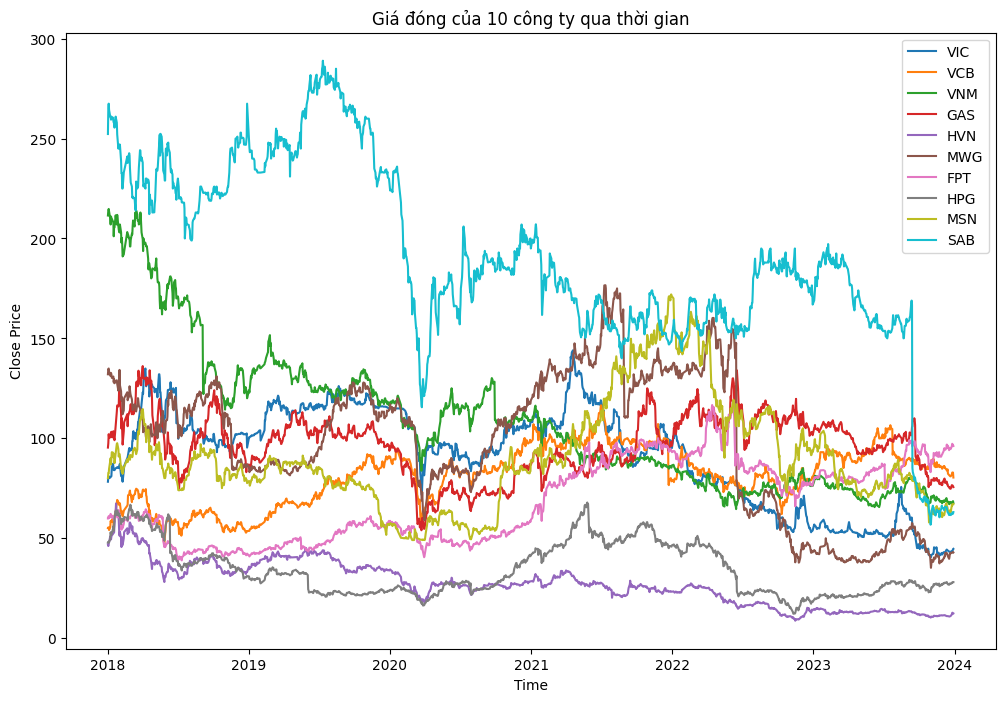

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Giá đóng của 10 công ty qua thời gian")

for symbol in stock_symbols:
  plt.plot(stock_data[symbol].index, stock_data[symbol]['close'], label=symbol)

plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#- Tiền xử lý dữ liệu -

#Kiểm tra tính dừng của các chuỗi

Ta sẽ tiến hành kiểm tra việc chuỗi giá đóng có tính dừng hay không để đảm bảo đủ điều kiện tiền đề khi hồi quy một mô hình chuỗi thời gian. Ta có thể kiểm định tính dừng bằng sử dụng kiểm định Argument Dickey Fuller.

Ta áp dụng lý thuyết kiểm định, đặt giả thuyết null rằng phương trình đặc biệt có nghiệm đơn vị và trong trường hợp ta tính được p-value < 0.05 thì ta sẽ chấp nhận giả thuyết thay thế là ngược lại của giả thuyết null.

In [ ]:
d_values = {}

for symbol in stock_symbols:
  d = 0
  p = 1
  price = stock_data[symbol]['close']
  adf = adfuller(price, regression = 'c')
  if(adf[1] < 0.05):
    print('ADF test cho %s' % symbol)
    print('ADF stat: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('d: %d' % d)
    d_values[symbol] = d
  else:
    while(adf[1] > 0.05):
      price = np.diff(price, axis=0)
      adf = adfuller(price, regression = 'c')
      d += 1
    print('ADF test cho %s' % symbol)
    print('ADF stat: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('d: %d' % d)
    d_values[symbol] = d
  print('')

ADF test cho VIC
ADF stat: -36.646665
p-value: 0.000000
d: 1

ADF test cho VCB
ADF stat: -38.817790
p-value: 0.000000
d: 1

ADF test cho VNM
ADF stat: -39.023844
p-value: 0.000000
d: 1

ADF test cho GAS
ADF stat: -2.865152
p-value: 0.049553
d: 0

ADF test cho HVN
ADF stat: -7.219460
p-value: 0.000000
d: 1

ADF test cho MWG
ADF stat: -39.564422
p-value: 0.000000
d: 1

ADF test cho FPT
ADF stat: -8.322540
p-value: 0.000000
d: 1

ADF test cho HPG
ADF stat: -11.162752
p-value: 0.000000
d: 1

ADF test cho MSN
ADF stat: -7.956583
p-value: 0.000000
d: 1

ADF test cho SAB
ADF stat: -37.045058
p-value: 0.000000
d: 1



In [ ]:
d_values

{'VIC': 1,
 'VCB': 1,
 'VNM': 1,
 'GAS': 0,
 'HVN': 1,
 'MWG': 1,
 'FPT': 1,
 'HPG': 1,
 'MSN': 1,
 'SAB': 1}

#-Tiến hành xây dựng mô hình ARIMA-



#Lựa chọn các tham số (p, d, q) cho ARIMA

### Xây dựng biểu đồ Tự tương quan (ACF) để tìm ra độ trễ của trung bình trượt MA

<Figure size 1800x600 with 0 Axes>

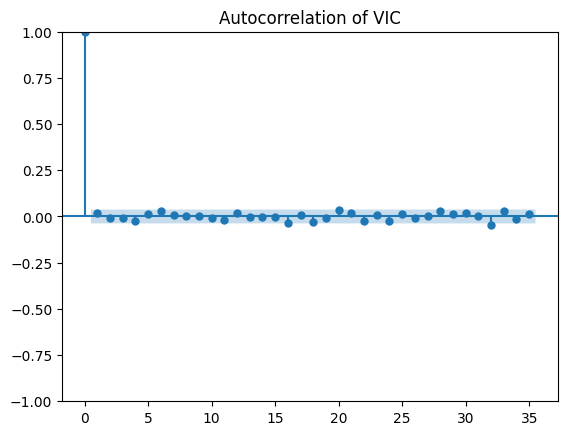

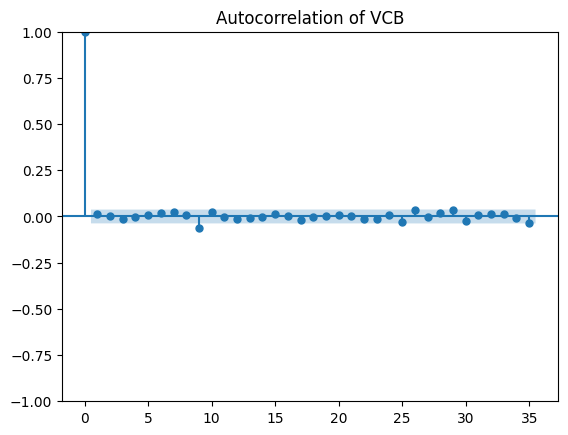

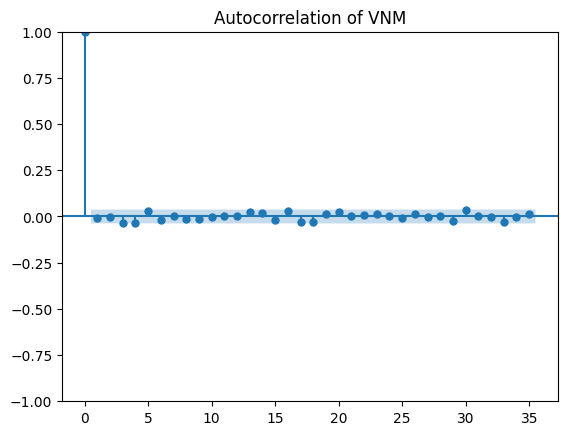

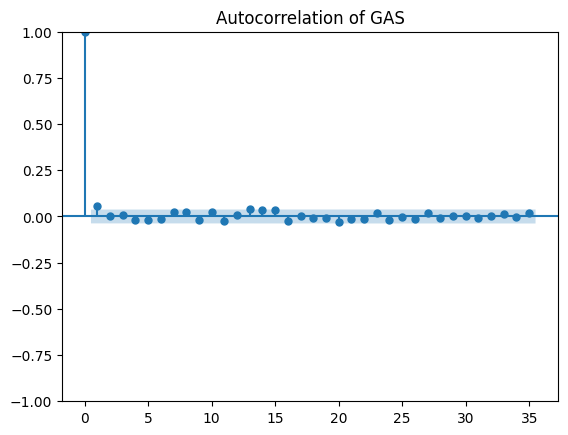

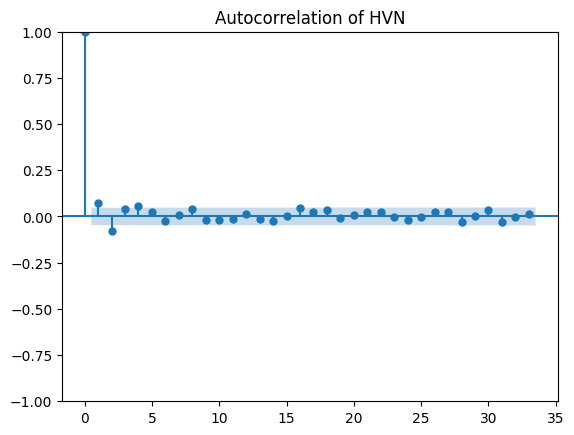

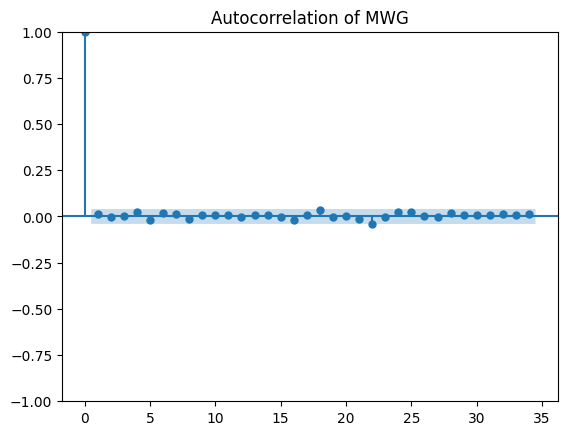

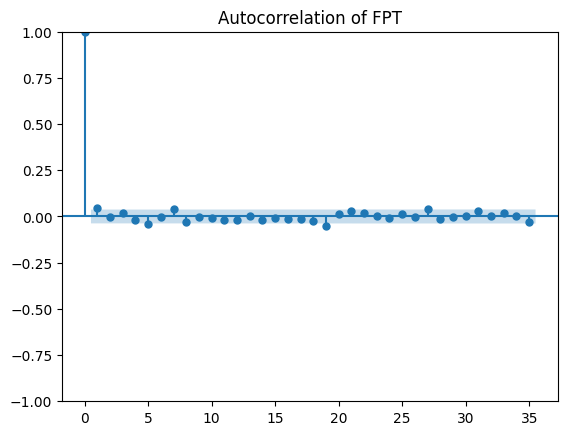

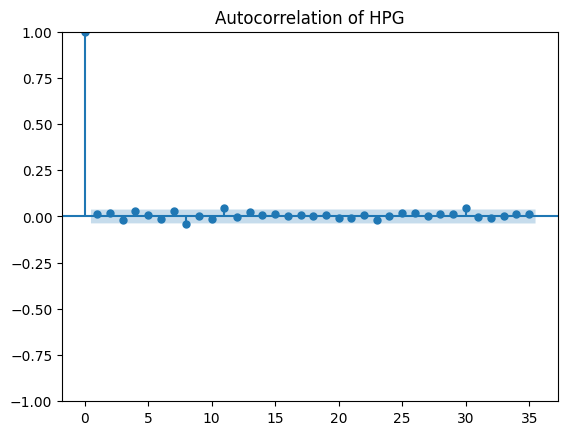

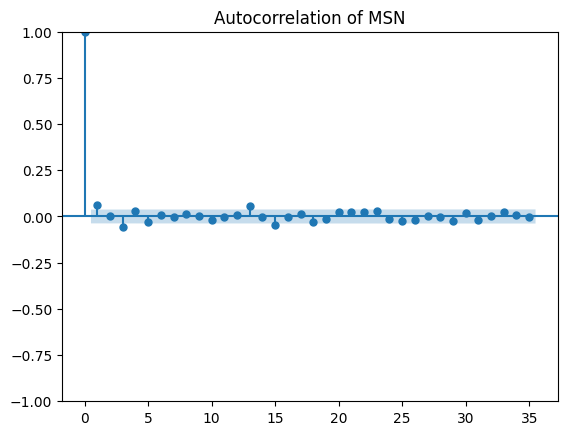

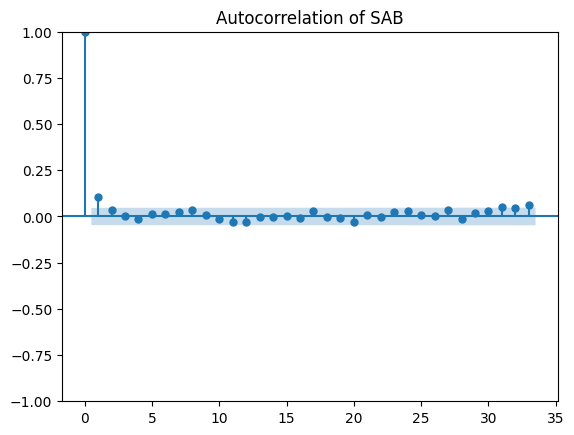

In [ ]:
plt.figure(figsize = (18,6))
for symbol in stock_symbols:
  ax = plot_acf(p_c[symbol])
  plt.title("Autocorrelation of %s" % symbol)
  plt.show()

Nhìn chung tại cấc biểu ACF của các công ty. Ta thấy rằng đối với từng biểu đồ tự tương quan của mỗi chuỗi lợi suất khác nhau, có những biểu đồ mà hệ số tự , tương quan khác không có thể thấy rõ ràng nhất là ở các hệ số như 1, 3, 13, 15, 19, 22. Nên qua đó ta có thể lựa chọn q = 22 là hệ số tự tương quan lớn nhất.

### Xây dựng biểu đồ Tự tương quan riêng phần (PACF) để lựa chọn tham số hệ số bậc tự do của quá trình tự qui hồi AR

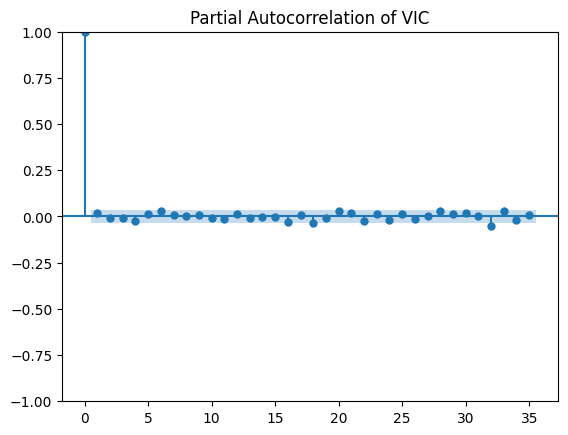

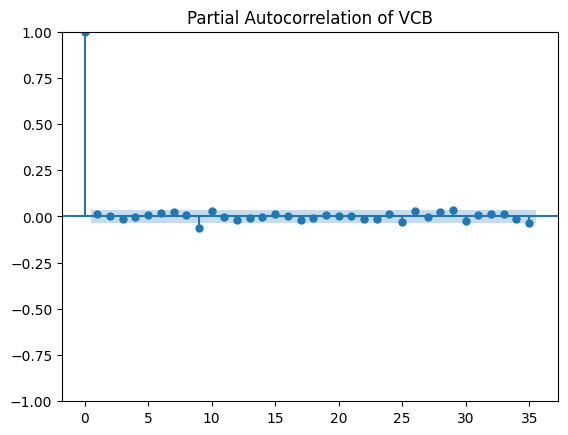

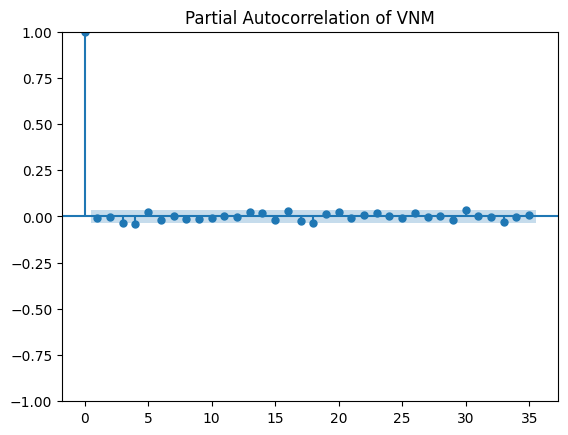

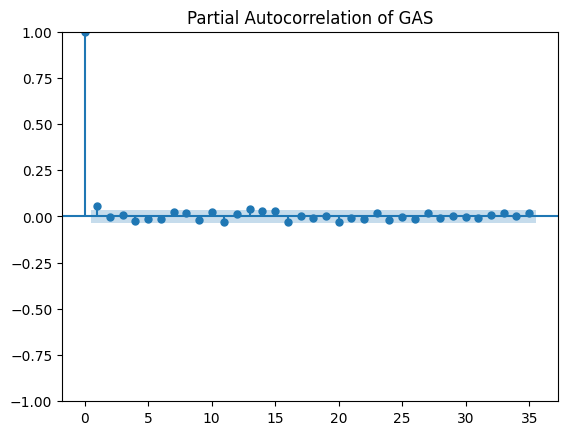

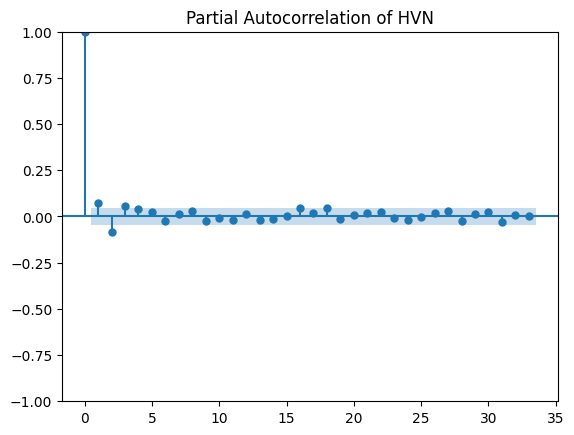

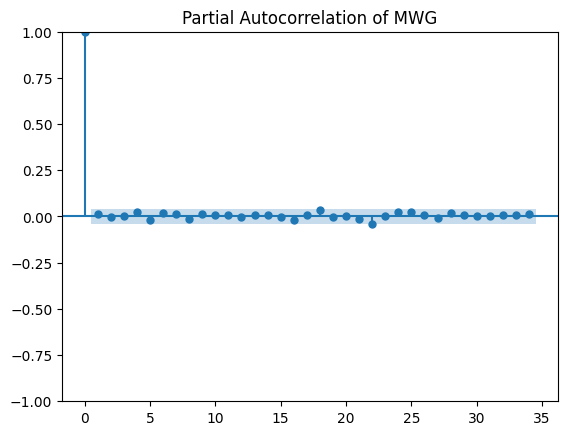

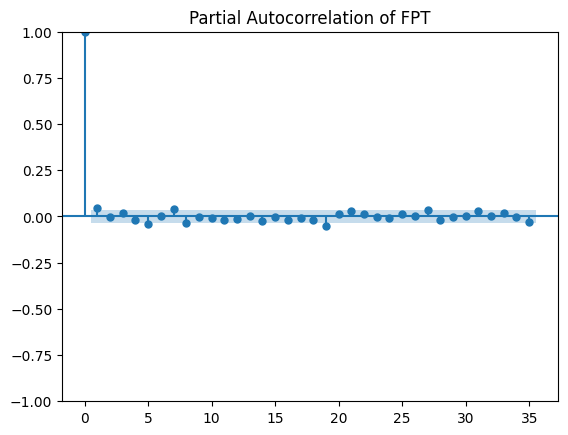

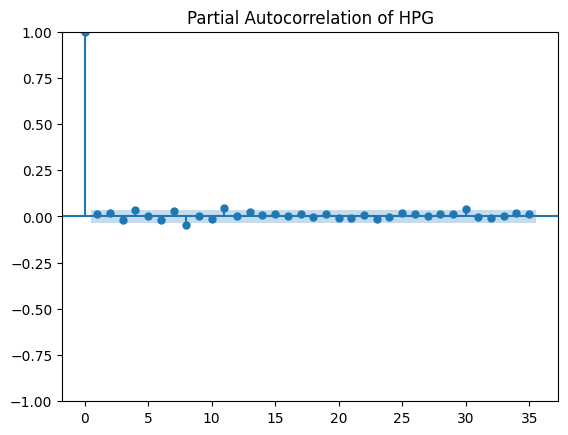

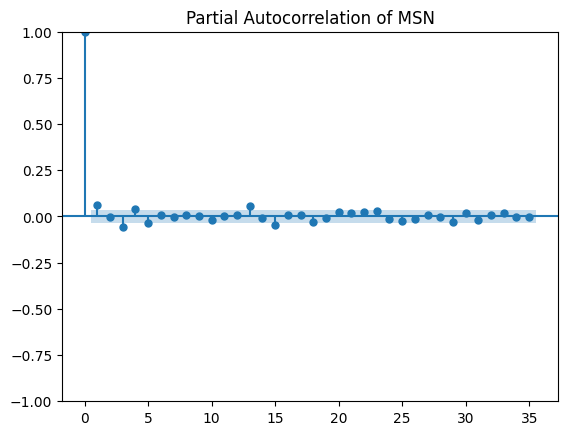

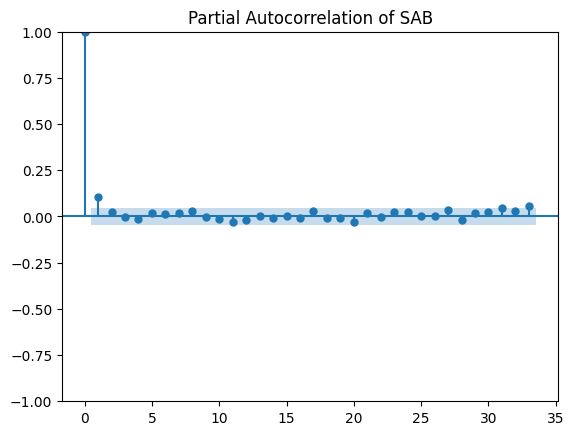

In [ ]:
for symbol in stock_symbols:
  ax = plot_pacf(p_c[symbol])
  plt.title("Partial Autocorrelation of %s" % symbol)
  plt.show()

Về biểu đồ tự tương quan riêng phần, thông qua các biểu đồ, ta thấy rằng các hệ số tự tương quan riêng phần khác 0 có thể thấy rõ ràng ở các hệ số 1, 2, 3, 7, 8, 10, 15. Vậy ta lựa chọn p = 15 là hệ số tự tương quan riêng phần lớn nhất.

#Tìm ra mô hình ARIMA tốt nhất

##Chia tập dữ liệu thành các tập train / test

Để thuận tiện hơn cho việc huấn luyện mô hình, ta sẽ phân chia tập dữ liệu train/test thành các tập sao cho dữ liệu huấn luyện sẽ là dữ liệu trước ngày 01-01-2023 và dữ liệu kiểm tra sẽ là từ sau ngày 01-01-2023.

In [ ]:
train_data = {}
test_data = {}
for symbol in stock_symbols:
  df_log = (stock_data[symbol]['close'])
  train_data[symbol] = np.log(df_log[:int(len(df_log)*0.8)])
  test_data[symbol] = np.log(df_log[int(len(df_log)*0.8):])


In [ ]:
print('Train data: ', train_data['VIC'])
print('Test data: ', test_data['VIC'])

Train data:  Symbols          VIC
date                
2018-01-02  4.359270
2018-01-03  4.388257
2018-01-04  4.394449
2018-01-05  4.382027
2018-01-08  4.385770
...              ...
2022-10-14  4.089332
2022-10-17  4.025352
2022-10-18  4.067316
2022-10-19  4.069027
2022-10-20  4.070735

[1198 rows x 1 columns]
Test data:  Symbols          VIC
date                
2022-10-21  4.039536
2022-10-24  4.034241
2022-10-25  4.027136
2022-10-26  4.003690
2022-10-27  4.007333
...              ...
2023-12-25  3.770459
2023-12-26  3.773910
2023-12-27  3.775057
2023-12-28  3.794365
2023-12-29  3.797734

[300 rows x 1 columns]


##Tìm ra mô hình ARIMA tốt nhất

Ta đã tìm ra được các tham số cần thiết cho mô hình ARIMA với các tham số q linh hoạt từ 0 đến 22 và các tham số p linh hoạt từ 0 đến 15. Với tham số d ta sẽ lựa chọn bằng 0 vì chuỗi lợi suất là chuỗi dừng. Ta sẽ tìm ra mô hình ARIMA tốt nhất thông qua tiêu chí là chỉ số AIC (Akaike Infomation Criteria).

In [ ]:
best_params = {}

for symbol in stock_symbols:
  print('Mô hình ARIMA tốt nhất cho %s' % symbol)
  best_ARIMA = auto_arima(train_data[symbol], start_p = 0, start_q = 0,
                          test='adf', max_p = 10, max_q = 10, m = 1,
                          start_P = 0, seasonal = False, d = d_values[symbol], D = 0,
                          trace = True, error_action = 'ignore',
                          suppress_warnings = True, stepwise = True)
  best_params[symbol] = best_ARIMA.get_params()['order']

Mô hình ARIMA tốt nhất cho VIC
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6039.551, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6039.596, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6039.610, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6041.366, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6037.620, Time=1.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.589 seconds
Mô hình ARIMA tốt nhất cho VCB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5892.520, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5890.711, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5890.711, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5894.416, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5888.623, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.190 seconds
Mô hình ARIMA tốt nhất cho V

In [ ]:
print(best_params)

{'VIC': (0, 1, 0), 'VCB': (0, 1, 0), 'VNM': (1, 1, 1), 'GAS': (1, 0, 1), 'HVN': (0, 1, 2), 'MWG': (0, 1, 0), 'FPT': (0, 1, 0), 'HPG': (0, 1, 0), 'MSN': (4, 1, 0), 'SAB': (1, 1, 0)}


##Khởi chạy mô hình ARIMA

In [ ]:
model_fitted = {}

for symbol in stock_symbols:
  model_ARIMA = ARIMA(train_data[symbol], order=best_params[symbol])
  model_fitted[symbol] = model_ARIMA.fit()
  print(model_fitted[symbol].summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

                               SARIMAX Results                                
Dep. Variable:                    VIC   No. Observations:                 1198
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3021.683
Date:                Mon, 22 Jan 2024   AIC                          -6041.366
Time:                        01:23:55   BIC                          -6036.278
Sample:                             0   HQIC                         -6039.449
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   7.16e-06     52.440      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.05   Jarque-Bera (JB):              2630.67
Prob(Q):                              0.15   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

                               SARIMAX Results                                
Dep. Variable:                    VNM   No. Observations:                 1198
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3115.981
Date:                Mon, 22 Jan 2024   AIC                          -6225.963
Time:                        01:23:56   BIC                          -6210.700
Sample:                             0   HQIC                         -6220.213
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7872      0.372      2.117      0.034       0.059       1.516
ma.L1         -0.8038      0.361     -2.226      0.026      -1.512      -0.096
sigma2         0.0003    3.5e-06     91.800      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    HVN   No. Observations:                 1194
Model:                 ARIMA(0, 1, 2)   Log Likelihood                2672.218
Date:                Mon, 22 Jan 2024   AIC                          -5338.436
Time:                        01:23:57   BIC                          -5323.183
Sample:                             0   HQIC                         -5332.689
                               - 1194                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0853      0.019      4.610      0.000       0.049       0.122
ma.L2         -0.0482      0.022     -2.232      0.026      -0.090      -0.006
sigma2         0.0007   1.63e-05     40.772      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    MWG   No. Observations:                 1198
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2460.758
Date:                Mon, 22 Jan 2024   AIC                          -4919.515
Time:                        01:23:57   BIC                          -4914.428
Sample:                             0   HQIC                         -4917.598
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0010   4.32e-06    222.104      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1326972.40
Prob(Q):                              1.00   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    FPT   No. Observations:                 1198
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2941.978
Date:                Mon, 22 Jan 2024   AIC                          -5881.956
Time:                        01:23:57   BIC                          -5876.869
Sample:                             0   HQIC                         -5880.040
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   4.78e-06     89.770      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):             32478.51
Prob(Q):                              0.25   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    MSN   No. Observations:                 1198
Model:                 ARIMA(4, 1, 0)   Log Likelihood                2819.384
Date:                Mon, 22 Jan 2024   AIC                          -5628.768
Time:                        01:23:59   BIC                          -5603.330
Sample:                             0   HQIC                         -5619.184
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0889      0.023      3.918      0.000       0.044       0.133
ar.L2          0.0230      0.025      0.937      0.349      -0.025       0.071
ar.L3         -0.0760      0.026     -2.884      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    SAB   No. Observations:                 1198
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3104.393
Date:                Mon, 22 Jan 2024   AIC                          -6204.786
Time:                        01:23:59   BIC                          -6194.611
Sample:                             0   HQIC                         -6200.953
                               - 1198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1000      0.018      5.634      0.000       0.065       0.135
sigma2         0.0003   8.18e-06     39.993      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

##Dự đoán với mô hình ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


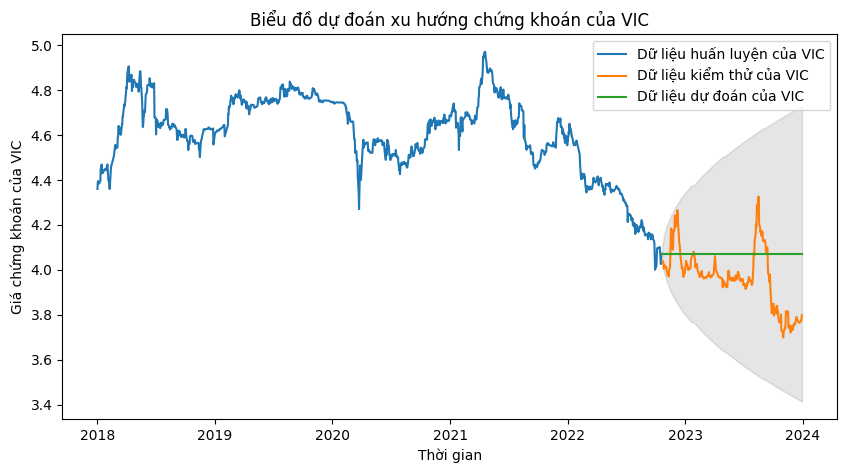

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


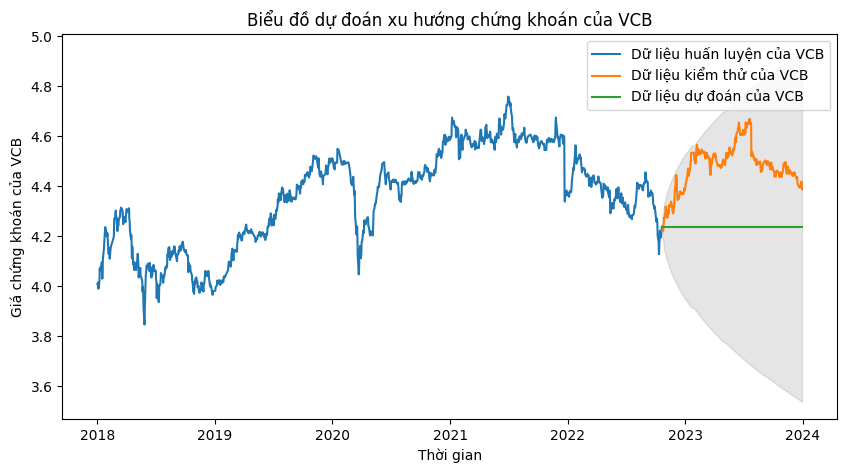

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


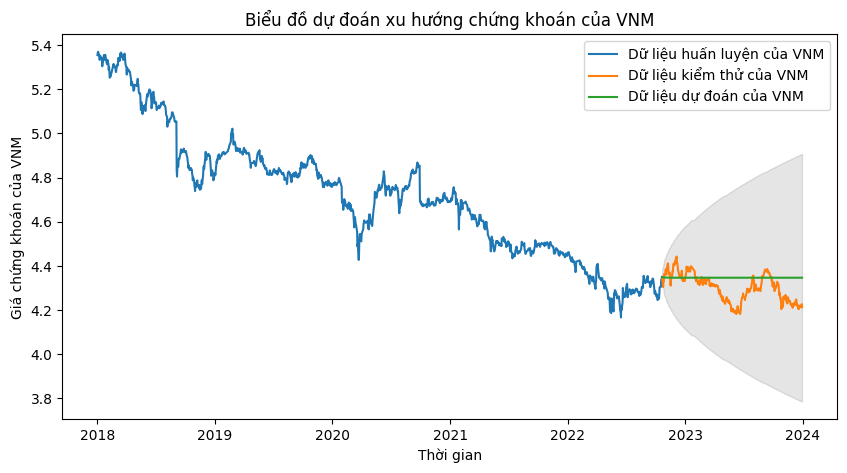

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


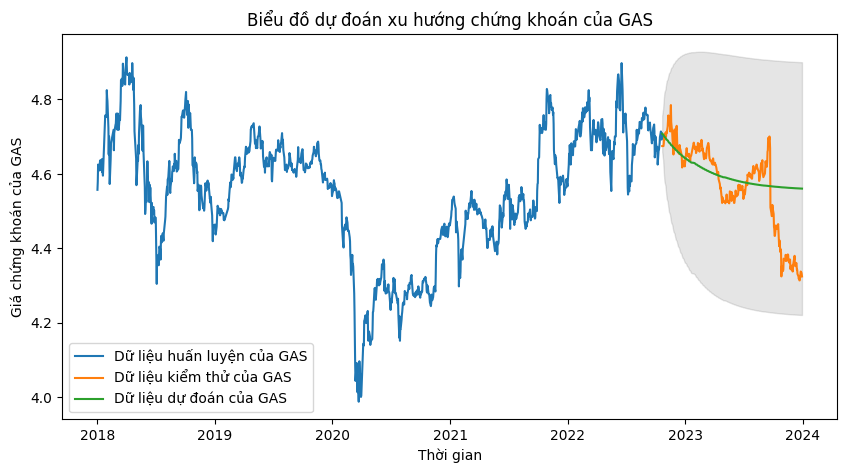

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


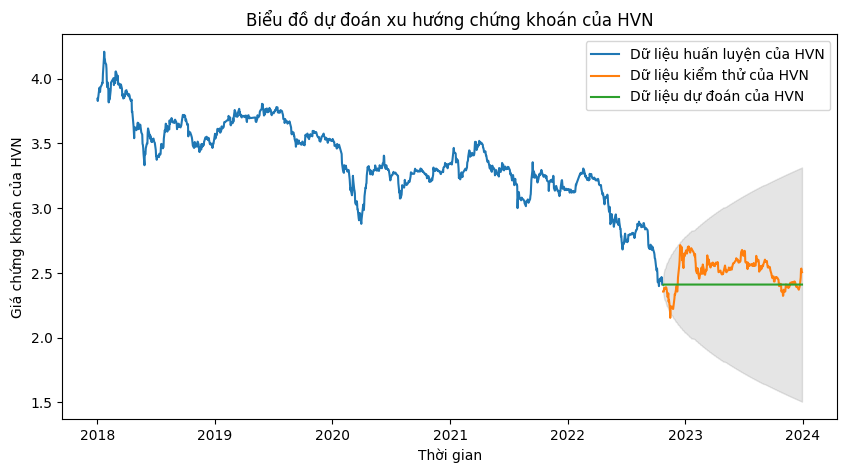

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


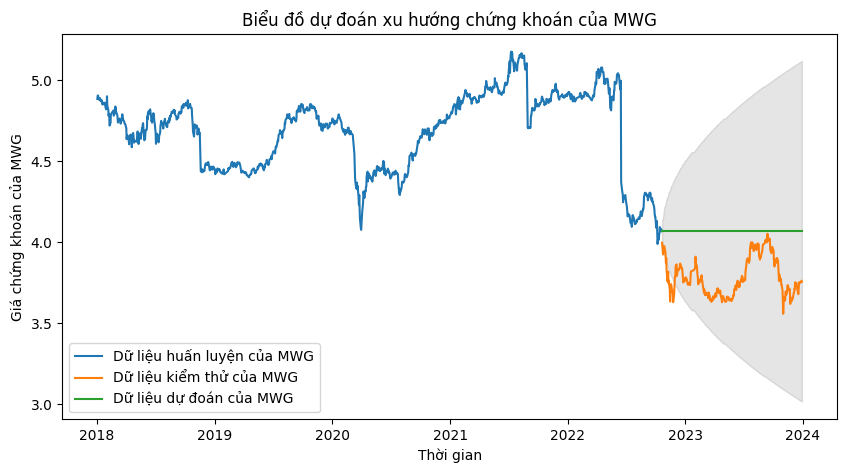

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


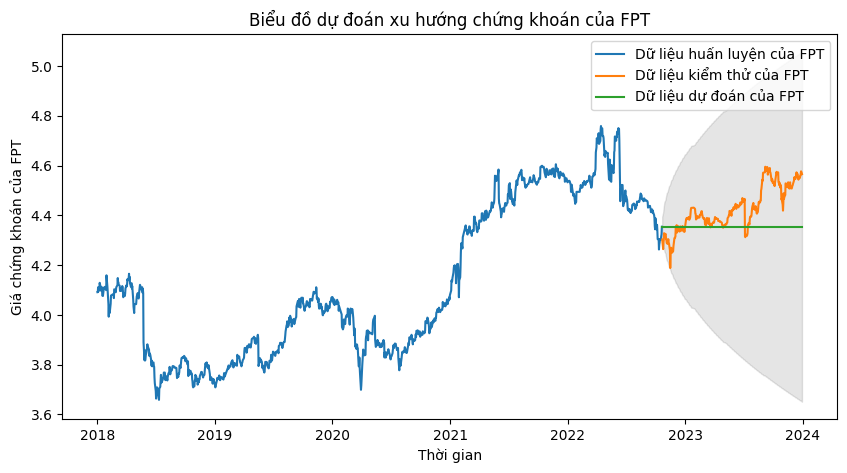

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


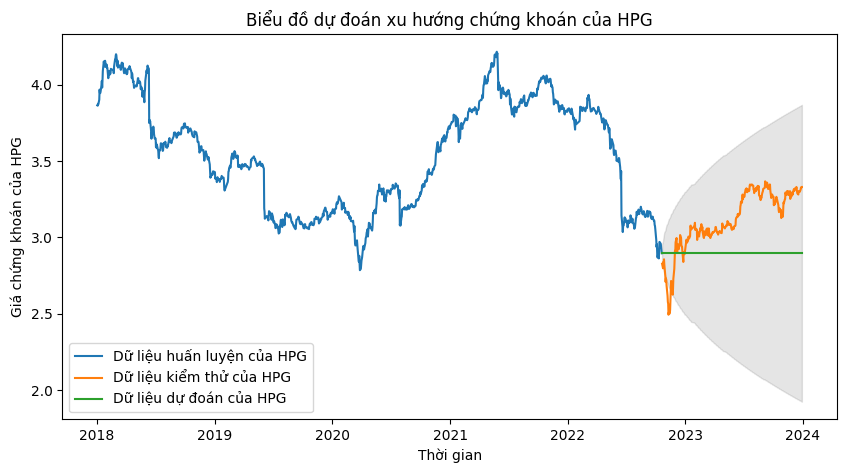

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


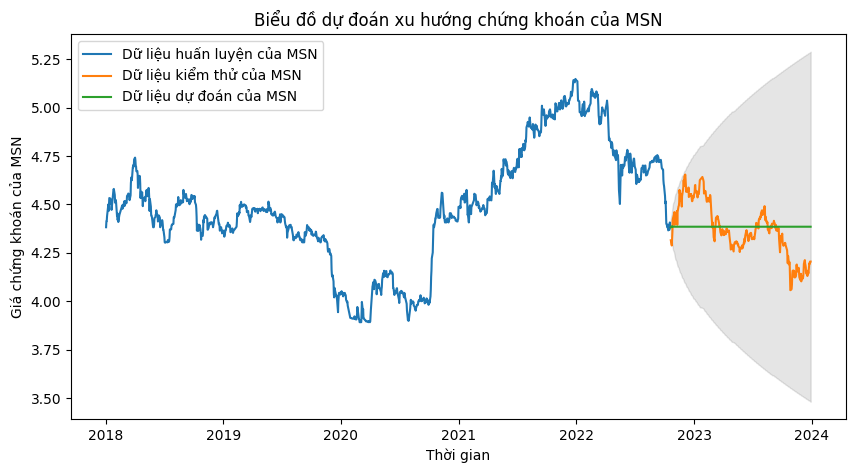

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


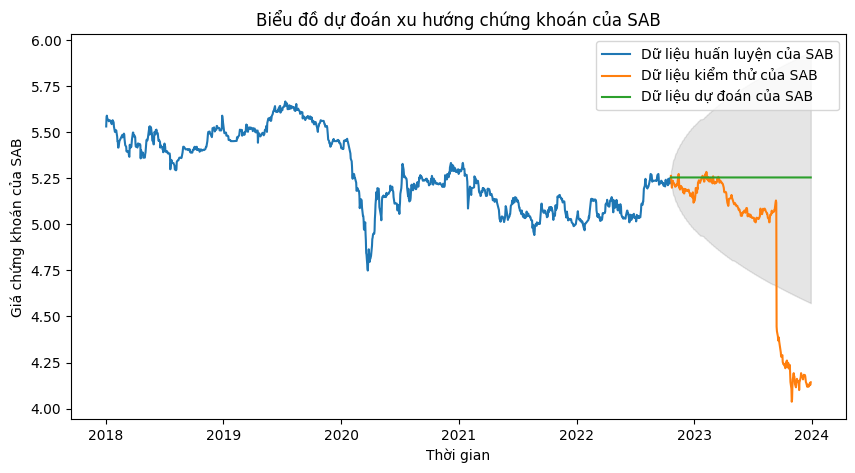

In [ ]:
fc_series = {}
lower_series = {}
upper_series = {}

for symbol in stock_symbols:
  predict = model_fitted[symbol].get_forecast(len(test_data[symbol]))
  fc_values = predict.predicted_mean.values
  conf = predict.conf_int(alpha=0.05)
  fc_series[symbol] = pd.Series(fc_values, index=test_data[symbol].index.values)
  lower_series[symbol] = pd.Series(conf['lower %s' % symbol].values, index=test_data[symbol].index.values)
  upper_series[symbol] = pd.Series(conf['upper %s' % symbol].values, index=test_data[symbol].index.values)

  plt.figure(figsize=(10,5), dpi=100)
  plt.plot(train_data[symbol], label="Dữ liệu huấn luyện của %s" % symbol)
  plt.plot(test_data[symbol], label="Dữ liệu kiểm thử của %s" % symbol)
  plt.plot(fc_series[symbol], label="Dữ liệu dự đoán của %s" % symbol)
  plt.fill_between(lower_series[symbol].index, lower_series[symbol], upper_series[symbol],
                 color='k', alpha=.10)
  plt.title('Biểu đồ dự đoán xu hướng chứng khoán của %s' % symbol)
  plt.xlabel('Thời gian')
  plt.ylabel('Giá chứng khoán của %s' % symbol)
  plt.legend()
  plt.show()





##Đánh giá accuracy của mô hình

In [ ]:
for symbol in stock_symbols:
  print('Accuracy của %s' % symbol)
  mse = mean_squared_error(test_data[symbol], fc_series[symbol].values)
  print('MSE: '+str(mse))
  mae = mean_absolute_error(test_data[symbol], fc_series[symbol].values)
  print('MAE: '+str(mae))
  rmse = math.sqrt(mean_squared_error(test_data[symbol], fc_series[symbol].values))
  print('RMSE: '+str(rmse))
  get_values = fc_series[symbol].values.reshape(len(fc_series[symbol].values),1)
  mape = np.mean(np.abs(get_values - test_data[symbol])/np.abs(test_data[symbol]))
  print('MAPE: '+str(mape.values))
  print('\n')

Accuracy của VIC
MSE: 0.028676560017926834
MAE: 0.14064863417868376
RMSE: 0.16934154841008994
MAPE: [0.03611858]


Accuracy của VCB
MSE: 0.06512779823493972
MAE: 0.23969199471924985
RMSE: 0.2552014855656991
MAPE: [0.05317703]


Accuracy của VNM
MSE: 0.005880024946227627
MAE: 0.06133859338562132
RMSE: 0.07668132071259354
MAPE: [0.01439413]


Accuracy của GAS
MSE: 0.009594037113798325
MAE: 0.0700554440076235
RMSE: 0.09794915575847668
MAPE: [0.01567579]


Accuracy của HVN
MSE: 0.020932065608005708
MAE: 0.12425403600587687
RMSE: 0.1446791816675976
MAPE: [0.04879462]


Accuracy của MWG
MSE: 0.093712667916552
MAE: 0.28328278521876304
RMSE: 0.30612524874069436
MAPE: [0.07585861]


Accuracy của FPT
MSE: 0.012792024637745782
MAE: 0.08818648408252472
RMSE: 0.11310183304326142
MAPE: [0.01966835]


Accuracy của HPG
MSE: 0.08428887729132045
MAE: 0.25668196945621846
RMSE: 0.29032546786549823
MAPE: [0.08092635]


Accuracy của MSN
MSE: 0.01923616793819286
MAE: 0.11099187016566807
RMSE: 0.1386945130067

#-Tiến hành xây dựng mô hình LSTM-

##Thêm các thư viện cần thiết để xây dựng mô hình LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

##Tiến hành tiền xử lý dữ liệu

Tiến hành scale lại dữ liệu để thuận tiện cho việc xây dựng mô hình

In [ ]:
stock_data = {}

for symbol in stock_symbols:
  df = dt.DataLoader(symbols=symbol,
                     start="2014-01-01",
                     end="2024-01-01",
                     minimal=True,
                     data_source="VND")
  stock_data[symbol] = df.download()

In [ ]:
stock_data_after_scale = {}
for symbol in stock_symbols:
  scale = MinMaxScaler(feature_range=(0,1))
  stock_data_after_scale[symbol] = scale.fit_transform(stock_data[symbol]['close'])
  print("%s:" % symbol, stock_data_after_scale[symbol])

VIC: [[0.28846154]
 [0.29326923]
 [0.29326923]
 ...
 [0.03461538]
 [0.04278846]
 [0.04423077]]
VCB: [[0.03131749]
 [0.03671706]
 [0.03563715]
 ...
 [0.63606911]
 [0.63714903]
 [0.61015119]]
VNM: [[0.46906188]
 [0.47571524]
 [0.47571524]
 ...
 [0.01996008]
 [0.02661344]
 [0.02062542]]
GAS: [[0.34401508]
 [0.33930254]
 [0.34872762]
 ...
 [0.43638077]
 [0.43355325]
 [0.42884072]]
HVN: [[0.52121315]
 [0.62003749]
 [0.6933038 ]
 ...
 [0.06798432]
 [0.06372465]
 [0.06202079]]
MWG: [[0.3128793 ]
 [0.34996628]
 [0.39042481]
 ...
 [0.05225893]
 [0.05360755]
 [0.05192178]]
FPT: [[0.11053985]
 [0.1092545 ]
 [0.11825193]
 ...
 [0.74678663]
 [0.74293059]
 [0.73650386]]
HPG: [[0.52064632]
 [0.52962298]
 [0.54219031]
 ...
 [0.28096948]
 [0.28456014]
 [0.28456014]]
MSN: [[0.31480777]
 [0.31100114]
 [0.31480777]
 ...
 [0.20060906]
 [0.20060906]
 [0.20060906]]
SAB: [[0.26673751]
 [0.29932696]
 [0.3340418 ]
 ...
 [0.01912859]
 [0.01948282]
 [0.02231668]]


##Tiến hành việc tạo các tập train và test

In [ ]:
data_train = {}
train_len = {}

for symbol in stock_symbols:
  df_log = (stock_data_after_scale[symbol])
  test_len = int(len(df_log)*0.2)
  train_len[symbol] = stock_data_after_scale[symbol].shape[0] - test_len
  timesteps = 30
  feature = 1

  X_train = []
  Y_train = []

  for i in range(timesteps, train_len[symbol]):
    X_train.append(stock_data_after_scale[symbol][i-timesteps:i,:])
    Y_train.append(stock_data_after_scale[symbol][i, :])

  X_train = np.asarray(X_train)
  Y_train = np.asarray(Y_train)

  data_train[symbol] = [X_train, Y_train]

  print('%s' % symbol)
  print("X train: ", data_train[symbol][0].shape)
  print("Y train: ", data_train[symbol][1].shape)
  print()


VIC
X train:  (1966, 30, 1)
Y train:  (1966, 1)

VCB
X train:  (1966, 30, 1)
Y train:  (1966, 1)

VNM
X train:  (1966, 30, 1)
Y train:  (1966, 1)

GAS
X train:  (1966, 30, 1)
Y train:  (1966, 1)

HVN
X train:  (1365, 30, 1)
Y train:  (1365, 1)

MWG
X train:  (1865, 30, 1)
Y train:  (1865, 1)

FPT
X train:  (1966, 30, 1)
Y train:  (1966, 1)

HPG
X train:  (1966, 30, 1)
Y train:  (1966, 1)

MSN
X train:  (1966, 30, 1)
Y train:  (1966, 1)

SAB
X train:  (1384, 30, 1)
Y train:  (1384, 1)



In [ ]:
data_test = {}

for symbol in stock_symbols:
  X_test = []
  Y_test = []

  for i in range(train_len[symbol], stock_data_after_scale[symbol].shape[0]):
    X_test.append(stock_data_after_scale[symbol][i-timesteps: i, :])
    Y_test.append(stock_data_after_scale[symbol][i, :])

  X_test = np.asarray(X_test)
  Y_test = np.asarray(Y_test)

  data_test[symbol] = [X_test, Y_test]

  print('%s' % symbol)
  print("X test: ", data_test[symbol][0].shape)
  print("Y test: ", data_test[symbol][1].shape)
  print()

VIC
X test:  (498, 30, 1)
Y test:  (498, 1)

VCB
X test:  (498, 30, 1)
Y test:  (498, 1)

VNM
X test:  (498, 30, 1)
Y test:  (498, 1)

GAS
X test:  (498, 30, 1)
Y test:  (498, 1)

HVN
X test:  (348, 30, 1)
Y test:  (348, 1)

MWG
X test:  (473, 30, 1)
Y test:  (473, 1)

FPT
X test:  (498, 30, 1)
Y test:  (498, 1)

HPG
X test:  (498, 30, 1)
Y test:  (498, 1)

MSN
X test:  (498, 30, 1)
Y test:  (498, 1)

SAB
X test:  (353, 30, 1)
Y test:  (353, 1)



##Xây dựng model

In [ ]:
lstm_model = {}

for symbol in stock_symbols:
  lstm_model[symbol] = Sequential()
  lstm_model[symbol].add(LSTM(32, return_sequences=True, input_shape=(timesteps, feature)))
  lstm_model[symbol].add(LSTM(32, return_sequences=False))
  lstm_model[symbol].add(Dense(30))
  lstm_model[symbol].add(Dense(1))
  lstm_model[symbol].compile(optimizer='adam', loss='mse')

In [ ]:
for symbol in stock_symbols:
  print('Chạy mô hình cho %s' % symbol)
  lstm_model[symbol].fit(X_train, Y_train, batch_size = 10, epochs=2)

Chạy mô hình cho VIC
Epoch 1/2
139/139 [==============================] - 8s 19ms/step - loss: 0.0107
Epoch 2/2
139/139 [==============================] - 3s 20ms/step - loss: 0.0014
Chạy mô hình cho VCB
Epoch 1/2
139/139 [==============================] - 8s 20ms/step - loss: 0.0089
Epoch 2/2
139/139 [==============================] - 3s 20ms/step - loss: 0.0016
Chạy mô hình cho VNM
Epoch 1/2
139/139 [==============================] - 10s 25ms/step - loss: 0.0072
Epoch 2/2
139/139 [==============================] - 3s 23ms/step - loss: 0.0012
Chạy mô hình cho GAS
Epoch 1/2
139/139 [==============================] - 7s 21ms/step - loss: 0.0101
Epoch 2/2
139/139 [==============================] - 3s 21ms/step - loss: 0.0012
Chạy mô hình cho HVN
Epoch 1/2
139/139 [==============================] - 7s 26ms/step - loss: 0.0086
Epoch 2/2
139/139 [==============================] - 3s 22ms/step - loss: 0.0013
Chạy mô hình cho MWG
Epoch 1/2
139/139 [==============================] - 6s 20ms/st

##Kiểm thử và đánh giá mô hình

In [ ]:
predict_values = {}

for symbol in stock_symbols:
  prediction = lstm_model[symbol].predict(data_test[symbol][0])
  prediction = scale.inverse_transform(prediction)
  test = scale.inverse_transform(data_test[symbol][1])
  rmse = np.sqrt(((test - prediction)**2).mean())
  print('RMSE của mô hình khi dự đoán %s: ' % symbol, rmse)
  predict_values[symbol] = prediction

16/16 [==============================] - 1s 7ms/step
RMSE của mô hình khi dự đoán VIC:  10.879355017703707
16/16 [==============================] - 1s 6ms/step
RMSE của mô hình khi dự đoán VCB:  10.630454698079632
16/16 [==============================] - 1s 7ms/step
RMSE của mô hình khi dự đoán VNM:  5.329693724347543
16/16 [==============================] - 1s 8ms/step
RMSE của mô hình khi dự đoán GAS:  12.78390388951828
11/11 [==============================] - 1s 7ms/step
RMSE của mô hình khi dự đoán HVN:  6.049674504713317
15/15 [==============================] - 1s 8ms/step
RMSE của mô hình khi dự đoán MWG:  18.301599384163687
16/16 [==============================] - 1s 8ms/step
RMSE của mô hình khi dự đoán FPT:  16.79580280759585
16/16 [==============================] - 1s 8ms/step
RMSE của mô hình khi dự đoán HPG:  12.86507856935842
16/16 [==============================] - 1s 10ms/step
RMSE của mô hình khi dự đoán MSN:  12.232879123100782
12/12 [==============================] - 

Symbols        VIC
date              
2022-01-04  101.00
2022-01-05  100.00
2022-01-06  104.50
2022-01-07  102.20
2022-01-10  102.30
...            ...
2023-12-25   43.40
2023-12-26   43.55
2023-12-27   43.60
2023-12-28   44.45
2023-12-29   44.60

[498 rows x 1 columns]
Symbols       VIC
date             
2014-01-02  70.00
2014-01-03  70.50
2014-01-06  70.50
2014-01-07  70.50
2014-01-08  70.00
...           ...
2023-12-25  43.40
2023-12-26  43.55
2023-12-27  43.60
2023-12-28  44.45
2023-12-29  44.60

[2494 rows x 1 columns]
Symbols        VIC       prdct
date                          
2022-01-04  101.00  213.968094
2022-01-05  100.00  213.376968
2022-01-06  104.50  213.154190
2022-01-07  102.20  213.704697
2022-01-10  102.30  214.464401
...            ...         ...
2023-12-25   43.40   74.866005
2023-12-26   43.55   74.879906
2023-12-27   43.60   74.911606
2023-12-28   44.45   74.959335
2023-12-29   44.60   75.098465

[498 rows x 2 columns]
Symbols      VCB
date            
2022-01-0

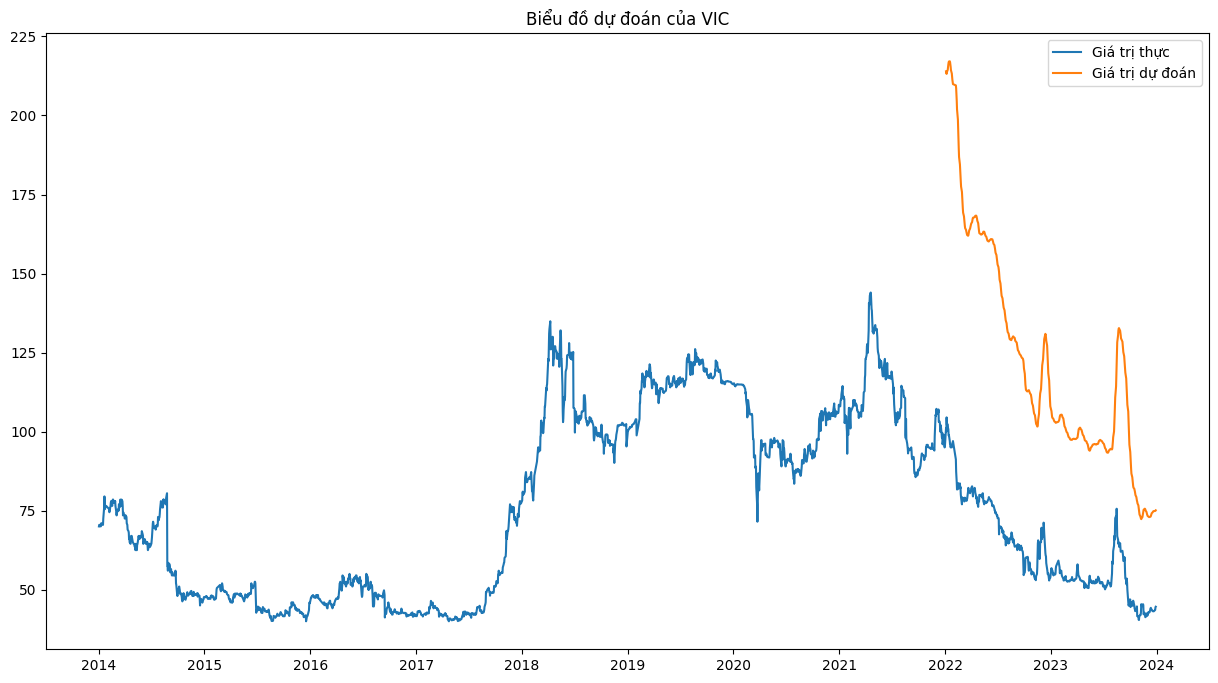

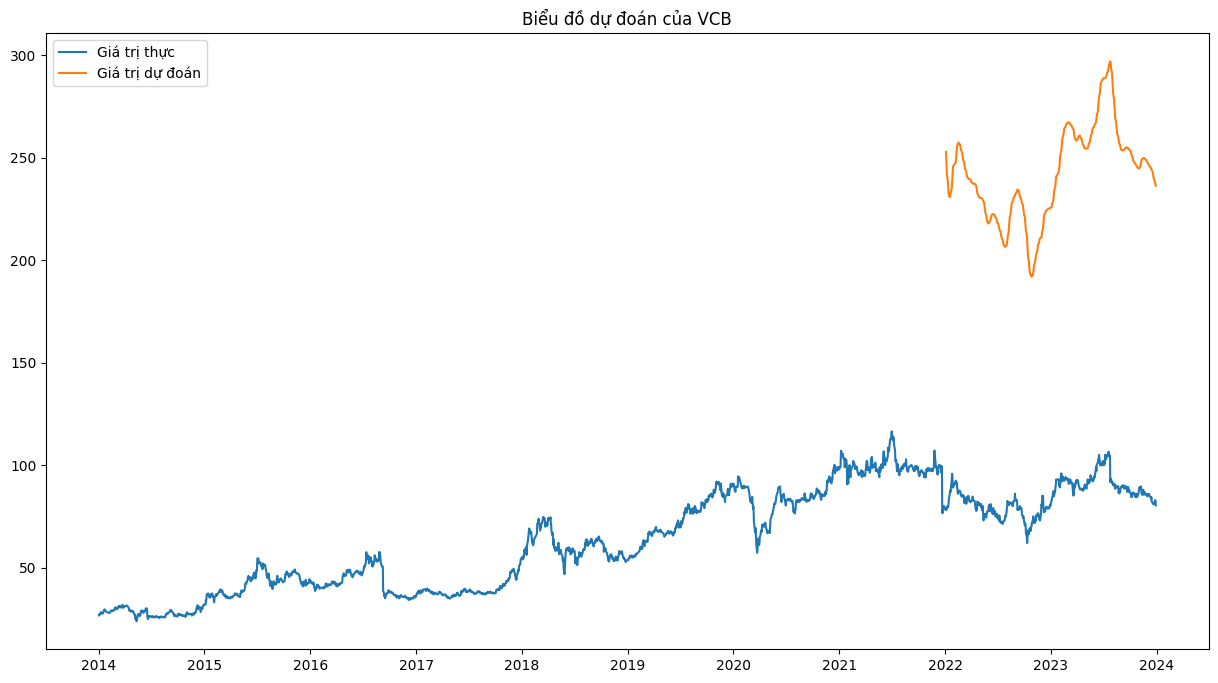

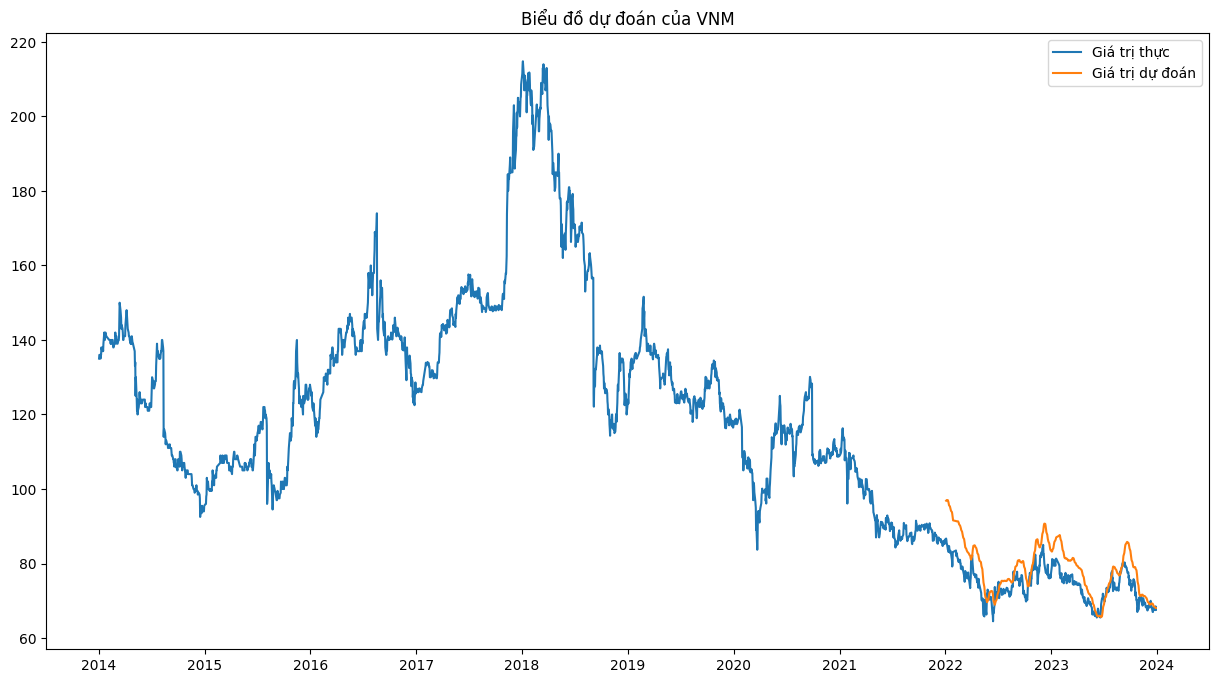

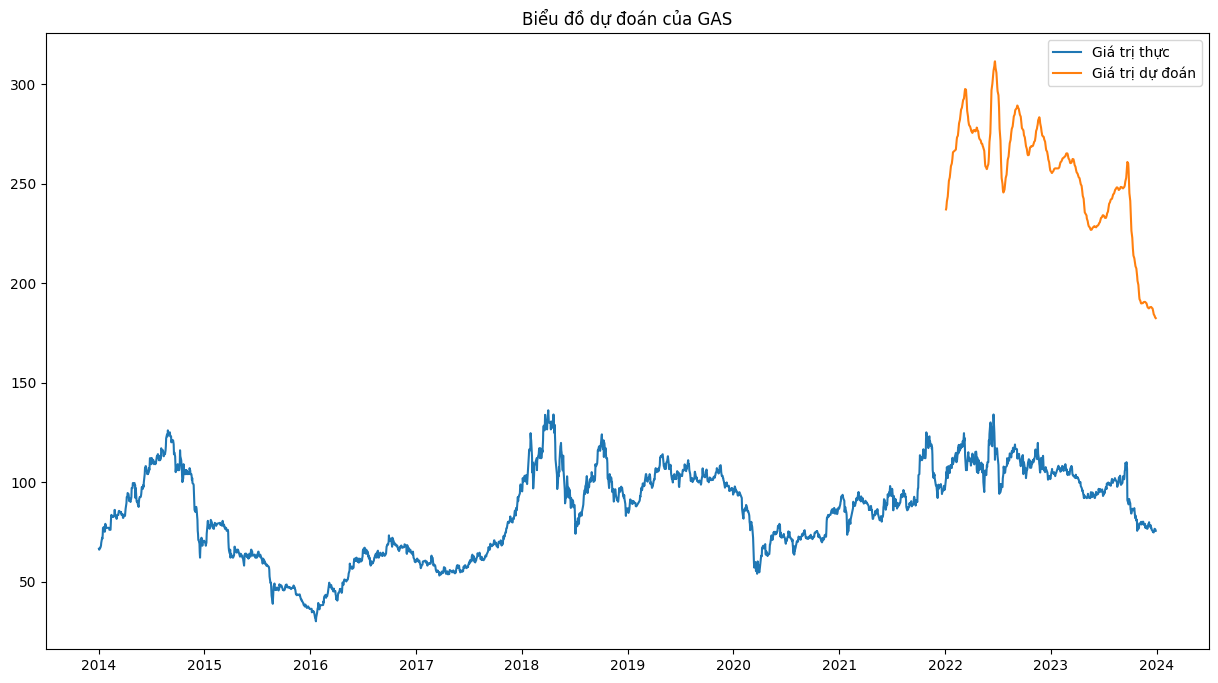

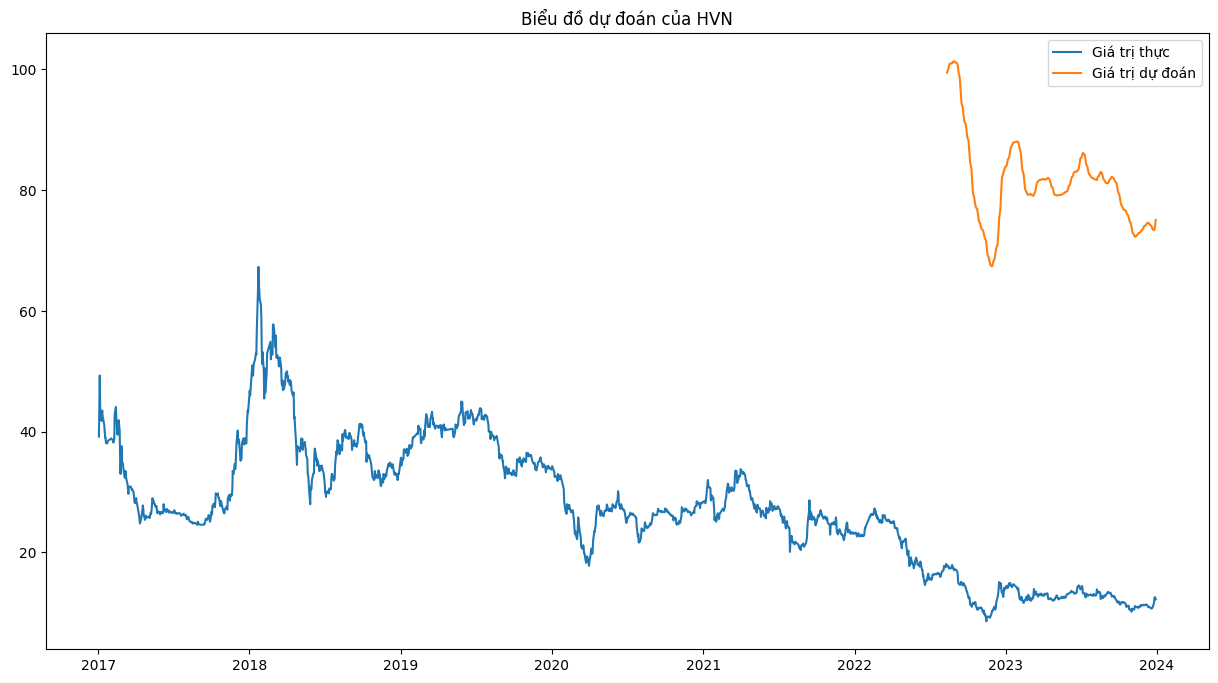

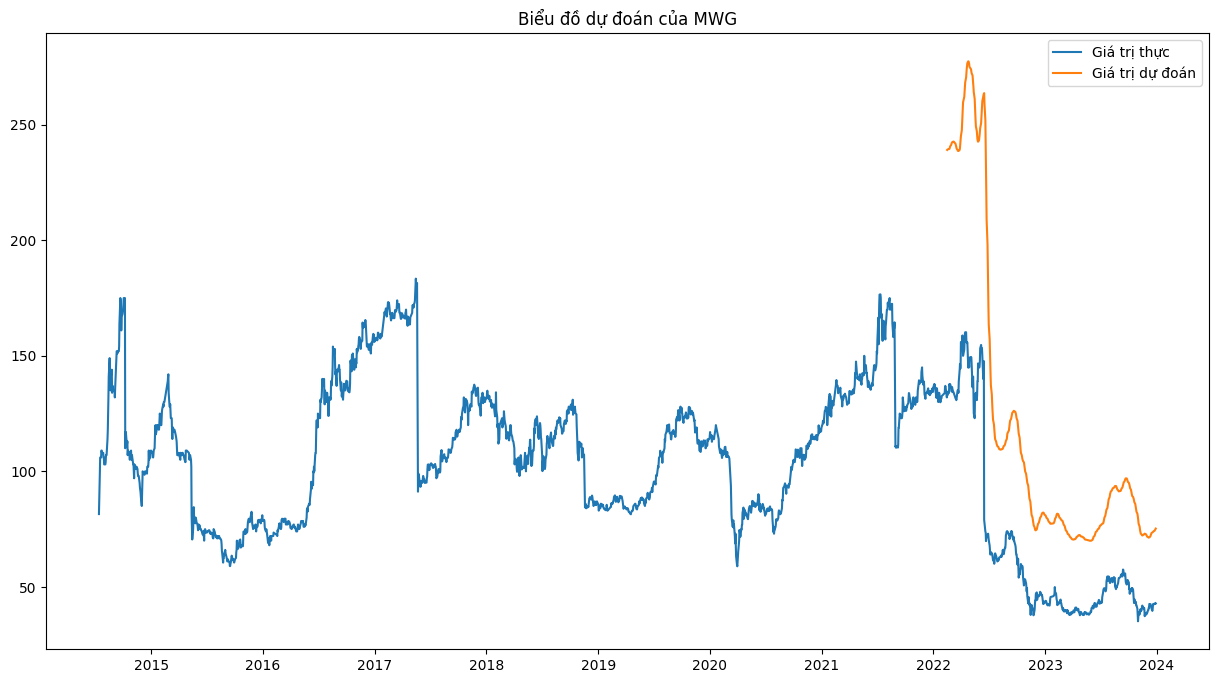

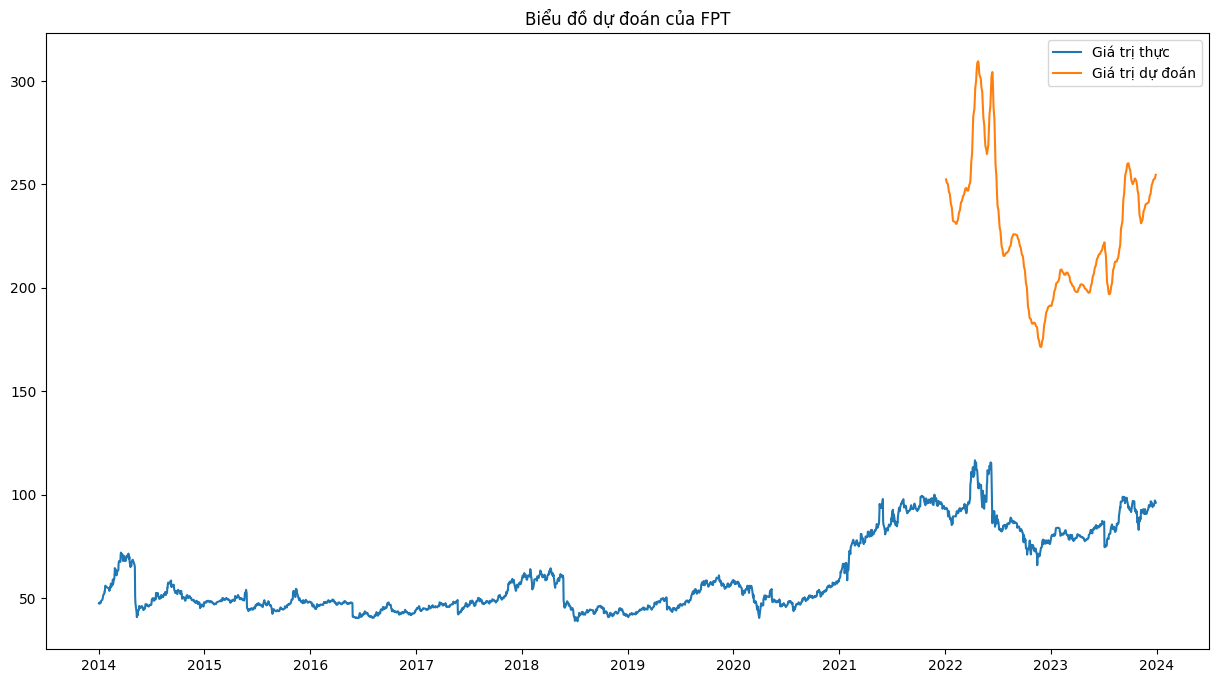

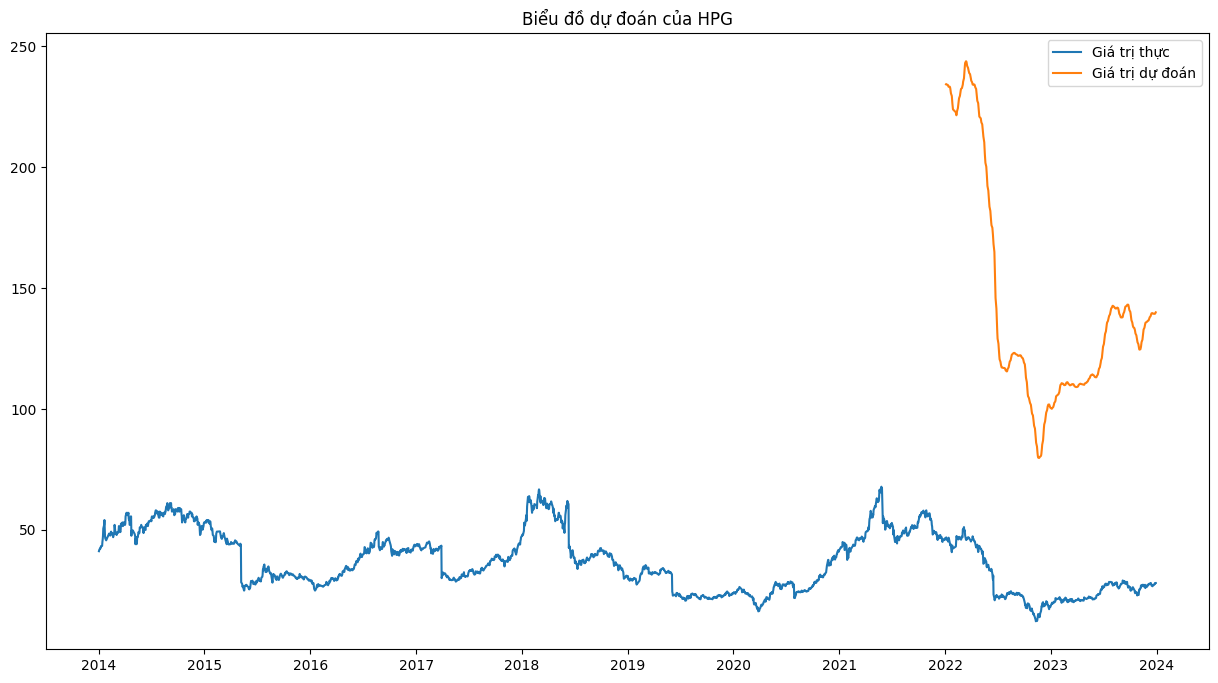

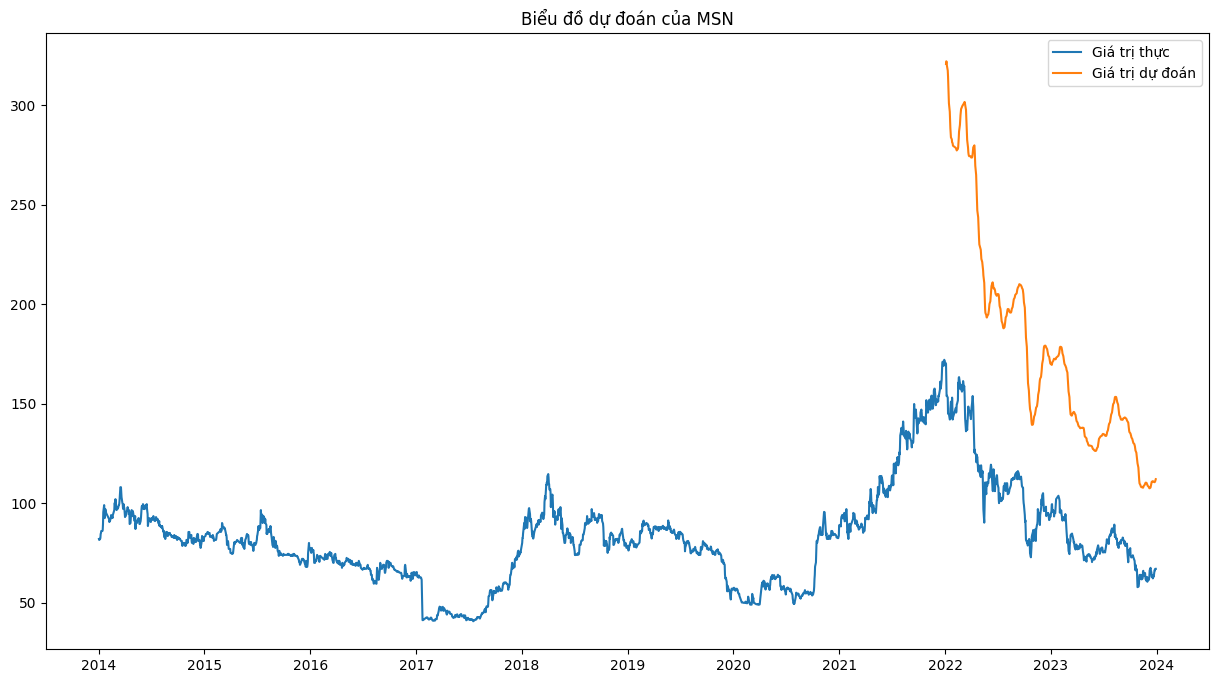

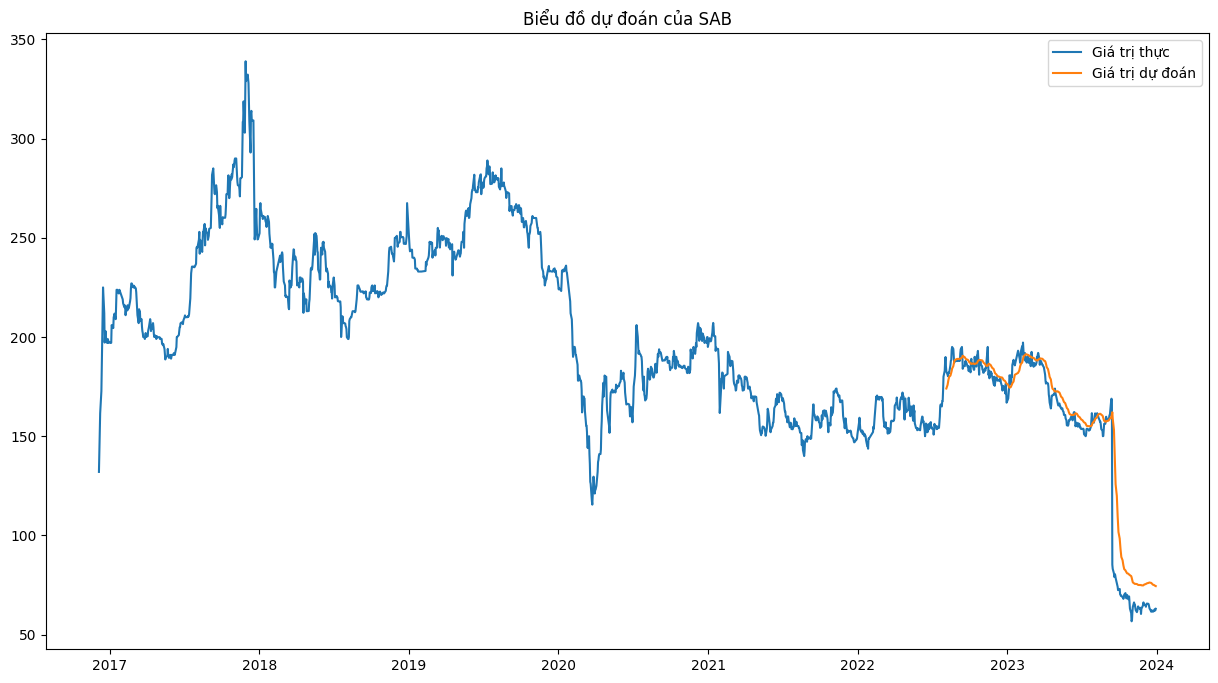

In [ ]:
for symbol in stock_symbols:
  real_data = stock_data[symbol]['close']
  predict = stock_data[symbol]['close'].iloc[train_len[symbol]:,:]
  print(predict)
  print(real_data)
  predict['prdct'] = predict_values[symbol]
  print(predict)
  plt.figure(figsize=(15,8))
  plt.plot(real_data, label='Giá trị thực')
  plt.plot(predict['prdct'], label='Giá trị dự đoán')
  plt.title('Biểu đồ dự đoán của %s' % symbol)
  plt.legend()
  plt.show